# **<center>Introduction</center>**

#### _This notebook prepares your environment for subsequent downloads and analysis. When set with the correct variables for your local system, running this notebook will create a script that loads shared packages and variables when imported into subsequent notebooks._

### **<center>Assignment background</center>**

---

This series of notebooks is an analysis and data visualization for the class "Python for Everybody" taught by Dr. Charles Severence (AKA "Dr. Chuck") at the University of Michigan, presented on Coursera. The assignment was to select an open dataset and do some sort of basic analysis and visualization in order to show that we have mastered the basic concepts taught in the course, such as web scraping, data cleaning, databases, and generation of plots.

From the provided list of open data sources, I went to [data.gov](https://data.gov/) and searched for datasets pertaining to New York City, my hometown. That led me to **[NYC OpenData](https://opendata.cityofnewyork.us/)**, where I got the datasets used here. After browsing the available datasets, I decided to go with real estate, as there are several large datasets pertaining to that topic that caught my eye, and I picked these for my analysis.

My hope is that I will design this analysis in a generic enough way that I can use large parts of its code in analyses of other NYC OpenData datasets.


### **<center>Finding and choosing datasets</center>**

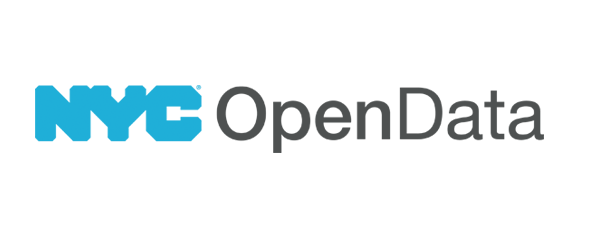

- ### [NYC Open Data Search page](https://data.cityofnewyork.us/browse?q=&sortBy=relevance)

  - [New York City Open Data](https://opendata.cityofnewyork.us/) is a repository of free public data published by New York City agencies and their partners. It is managed by the Open Data Team at the NYC Office of Technology and Innovation (OTI)

- ### Search terms:

  - "property", "housing", "easements", "land use"

- ### Selection of datasets:

  - I did not use any formal criteria to choose datasets, but I favored ones that were larger and included dollar amounts of money as at least one of their fields.

- ### Interesting datasets:
  - These datasets are all related to land use and housing and are cross-referenceable using borough, block, and lot. Although my analysis will only focus on one or two of the datasets, I want to bring together the related data for possible future analysis.
    - **Primary Land Use Tax Lot Output (PLUTO)**: Land use and geographic data at the tax lot level, includes assessed property values. [Dataset main page is here](https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-PLUTO-/64uk-42ks/about_data).
    - **Property Valuation and Assessment Data**: The Department of Finance-assessed values for properties, evaluated every year as one step in calculating property tax bills. [Dataset main page is here](https://data.cityofnewyork.us/City-Government/Property-Valuation-and-Assessment-Data/yjxr-fw8i/about_data)
    - **Tax Lien Sale Lists**: Properties with tax, water liens and other charges that may be eligible for inclusion in the next lien sale, as well as tax liens which were eventually sold. [Dataset main page is here](https://data.cityofnewyork.us/City-Government/Tax-Lien-Sale-Lists/9rz4-mjek/about_data)
    - **Housing Maintenance Code Violations**: Violations against conditions, in rental dwelling units and buildings, that have been verified to violate the New York City Housing Maintenance Code (HMC) or the New York State Multiple Dwelling Law (MDL). [Dataset main page is here](https://data.cityofnewyork.us/Housing-Development/Housing-Maintenance-Code-Violations/wvxf-dwi5/about_data)
    - **Assessment Actions**: Tax Commission actions for reducing assessments or reclassifying property. [Dataset main page is here](https://data.cityofnewyork.us/City-Government/Assessment-Actions/4nft-bihw/about_data)
    - **Housing Database**: NYC Department of City Planning (DCP) Housing Database containing all NYC Department of Buildings (DOB)-approved housing construction and demolition jobs filed or completed in NYC since January 1, 2010. [Dataset main page is here](https://data.cityofnewyork.us/Housing-Development/Housing-Database/6umk-irkx/about_data). The dataset itself is hosted elsewhere, so the url creation strategy that I use for the other datasets will not work.

#### _For the selected datasets, the id should be the only thing needed to construct urls and set up the necessary variables. The id is in the url for the dataset main page between the name of the dataset and '/about_data', shown in bold: [https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-PLUTO-/**64uk-42ks**/about_data](https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-PLUTO-/64uk-42ks/about_data)_

---


# **<center>Environment setup</center>**

---

- ### Import the libraries used in this notebook


In [1]:
import os
import time
from dataclasses import dataclass, field
from typing import List
import re
import requests
from sqlalchemy import Integer, Float, String, Date, LargeBinary, Boolean
import dill
from src.helpers import *
from src.models import *


- ### Customize the directories to be used to where on your machine you want them.
  - #### Set paths for where to create the data folder where datasets will be downloaded and the sqlite database created. It will be at least several gigabytes if not more, so make sure you have space.


In [ ]:
# Directory where the data folder for this analysis is to be created
DATADIR = "/mnt/Datasets/PROJECTDATA"

# Name of the folder in which the project data is stored
PROJECT_NAME = "nyc_real_estate"

# MapPluto version, check website for latest
pluto_version = "25v1_1"

- ### Set the names and paths of the datasets to be used. Here they are already set for the analysis I am doing, but the hope is to make it as adaptable to other datasets as possible.


In [3]:
# Create paths that will be frequently used throughout the project
PROJECT_PATH = os.getcwd()
PROJECT_DATA = f"{DATADIR}/{PROJECT_NAME}_data"
SQLITE_PATH = f"sqlite:///{PROJECT_DATA}/{PROJECT_NAME}_db.sqlite"

* Create the directories

In [ ]:

# Create necessary directories from the paths
os.makedirs(
    PROJECT_DATA, exist_ok=True
)  # Make the main directory for the project downloads and data
os.makedirs(f"{PROJECT_DATA}/downloads", exist_ok=True)  # Make the download directory
# os.makedirs(
#     f"{PROJECT_DATA}/intermediate_files", exist_ok=True
# )  # Location for intermediate files
os.makedirs(
    f"{PROJECT_DATA}/files_to_use", exist_ok=True
)  # Location where cleaned data to be directly used in analysis is stored
os.makedirs(
    f"{PROJECT_DATA}/dictionaries", exist_ok=True
)  # Location where cleaned data to be directly used in analysis is stored
os.makedirs(
    f"{PROJECT_DATA}/figures", exist_ok=True
)  # Location where plots will go later on

- ### Create a dataclass to store metadata about the datasets.


- ### Create instances of the new dataclass for each dataset.

  - #### Create a dictionary of instances of the `Dataset` dataclass, one for each dataset I have chosen The keys are a shortened version of the dataset name that I made up. Values are the urls for the information pages that one finds when [searching the OpenData website](https://data.cityofnewyork.us/browse?q=&sortBy=relevance). Although it would take a lot of testing to verify, the intention is to be able to substitute a different set of urls and proceed through the notebook set with minimal modification. I opted not to use it this time, but if the code proves to be reusable, I could use a tool like [Papermill](https://papermill.readthedocs.io/en/latest/)


In [ ]:
dataset_info_dict = {
    "mapPLUTO": DatasetInfo(
        main_url="https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-Map-MapPLUTO-/f888-ni5f/about_data",
        standard=False,
        data_url=f"https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/mappluto/nyc_mappluto{pluto_version}_fgdb.zip",
        format="zip",
        geodata=True,
    ),
    "assessments": DatasetInfo(
        main_url="https://data.cityofnewyork.us/City-Government/Property-Valuation-and-Assessment-Data/yjxr-fw8i/about_data"
    ),
    "tax_liens": DatasetInfo(
        main_url="https://data.cityofnewyork.us/City-Government/Tax-Lien-Sale-Lists/9rz4-mjek/about_data"
    ),
    "housing_violations": DatasetInfo(
        main_url="https://data.cityofnewyork.us/Housing-Development/Housing-Maintenance-Code-Violations/wvxf-dwi5/about_data"
    ),
    "assessment_actions": DatasetInfo(
        main_url="https://data.cityofnewyork.us/City-Government/Assessment-Actions/4nft-bihw/about_data"
    ),
    "housing_database": DatasetInfo(
        main_url="https://data.cityofnewyork.us/Housing-Development/Housing-Database/6umk-irkx/about_data",
        standard=False,
        data_url="https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/nychousingdb_24q2_gdb.zip",
        format="zip",
        geodata=True,
    ),
    "NTAs2020": DatasetInfo(
        main_url="https://data.cityofnewyork.us/City-Government/2020-Neighborhood-Tabulation-Areas-NTAs-/9nt8-h7nd/about_data"
    ),
    "NTA_population_2020": DatasetInfo(
        main_url="https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Neighborhood-Tabulatio/swpk-hqdp/about_data"
    ),
    "NTA_demographics_2020": DatasetInfo(
        main_url="https://data.cityofnewyork.us/City-Government/Census-Demographics-at-the-Neighborhood-Tabulation/rnsn-acs2/about_data"
    ),
    "census_blocks2020": DatasetInfo(
        main_url="https://data.cityofnewyork.us/City-Government/2020-Census-Blocks/wmsu-5muw/about_data"
    ),
    "CDTAs2020": DatasetInfo(
        main_url="https://data.cityofnewyork.us/City-Government/2020-Community-District-Tabulation-Areas-CDTAs-/xn3r-zk6y/about_data"
    ),
    "puma2020": DatasetInfo(
        main_url="https://data.cityofnewyork.us/City-Government/2020-Public-Use-Microdata-Areas-PUMAs-/pikk-p9nv/about_data"
    ),
    "cert_of_occupancy": DatasetInfo(
        main_url="https://data.cityofnewyork.us/Housing-Development/DOB-Certificate-Of-Occupancy/bs8b-p36w/about_data"
    ),
}

- ### Inspect the metadata for the chosen datasets to get column names, data types, and cardinality for each column.


In [6]:
for short_name, dataset_info in dataset_info_dict.items():
    print(f"Getting metadata for {short_name}... {dataset_info.metadata_url}")
    response = requests.get(dataset_info.metadata_url, timeout=10)
    response.raise_for_status()
    metadata = response.json()
    data_dict = [
        (attachment["assetId"], attachment["filename"])
        for attachment in metadata["metadata"]["attachments"]
        if any(s in attachment["filename"].casefold() for s in ["dict", "dd"])
    ]
    if data_dict:
        dataset_info.data_dict_url = f"https://data.cityofnewyork.us/api/views/{dataset_info.id}/files/{data_dict[0][0]}?download=true&filename={data_dict[0][1]}"
    dataset_info.name = metadata["name"]
    dataset_info.short_name = short_name
    try:
        dataset_info.other_files = [
            (attachment["assetId"], attachment["filename"])
            for attachment in metadata["metadata"]["attachments"]
            if not any(s in attachment["filename"].casefold() for s in ["dict", "dd"])
        ]
    except KeyError:
        dataset_info.other_files = None
    try:
        dataset_info.attribution = metadata["attribution"]
    except KeyError:
        dataset_info.attribution = None
    try:
        dataset_info.createdAt = metadata["createdAt"]
    except KeyError:
        dataset_info.attribution = None
    try:
        dataset_info.description = metadata["description"]
    except KeyError:
        dataset_info.attribution = None
    try:
        dataset_info.provenance = metadata["provenance"]
    except KeyError:
        dataset_info.attribution = None
    try:
        dataset_info.publicationDate = metadata["publicationDate"]
    except KeyError:
        dataset_info.attribution = None
    try:
        dataset_info.rowsUpdatedAt = (
            (  # The column for when the dataset was last updated is usually called `rowsUpdatedAt`, but sometimes it's called `viewLastModified`
                metadata["rowsUpdatedAt"]
                if "rowsUpdatedAt" in metadata.keys()
                else (
                    metadata["viewLastModified"]
                    if "viewLastModified" in metadata.keys()
                    else None
                )
            ),
        )
    except KeyError:
        dataset_info.attribution = None
    time.sleep(5)

Getting metadata for mapPLUTO... https://data.cityofnewyork.us/api/views/f888-ni5f.json
Getting metadata for assessments... https://data.cityofnewyork.us/api/views/yjxr-fw8i.json
Getting metadata for tax_liens... https://data.cityofnewyork.us/api/views/9rz4-mjek.json
Getting metadata for housing_violations... https://data.cityofnewyork.us/api/views/wvxf-dwi5.json
Getting metadata for assessment_actions... https://data.cityofnewyork.us/api/views/4nft-bihw.json
Getting metadata for housing_database... https://data.cityofnewyork.us/api/views/6umk-irkx.json
Getting metadata for NTAs2020... https://data.cityofnewyork.us/api/views/9nt8-h7nd.json
Getting metadata for NTA_population_2020... https://data.cityofnewyork.us/api/views/swpk-hqdp.json
Getting metadata for NTA_demographics_2020... https://data.cityofnewyork.us/api/views/rnsn-acs2.json
Getting metadata for census_blocks2020... https://data.cityofnewyork.us/api/views/wmsu-5muw.json
Getting metadata for CDTAs2020... https://data.cityofne

* ### Download the datasets

In [7]:
for name, dataset_info in dataset_info_dict.items():
    print(name)
    print(dataset_info.data_url)
    downloader(
        url=dataset_info.data_url,
        download_path=f"{PROJECT_DATA}/downloads/",
        outfile_name=f"{dataset_info.short_name}.{dataset_info.format}",
        bigfile=True,
        chunk_size=8192,
    )
    if dataset_info.data_dict_url is not None:
        try:
            file_type = dataset_info.data_dict_url.split(".")[-1]
        except AttributeError:
            print(
                f"{RED}Could not parse filetype from {CYAN}{dataset_info.data_dict_url}{RESET}!"
            )
            continue
        print(dataset_info.data_dict_url)
        dataset_info.data_dict_path = downloader(
            url=dataset_info.data_dict_url,
            download_path=f"{PROJECT_DATA}/dictionaries/",
            outfile_name=f"{dataset_info.short_name}_data_dictionary.{file_type}",
            bigfile=False,
        )

mapPLUTO
https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/mappluto/nyc_mappluto_25v1_1_fgdb.zip
File already exists: /mnt/Datasets/PROJECTDATA/nyc_real_estate_data/downloads/mapPLUTO.zip
https://data.cityofnewyork.us/api/views/f888-ni5f/files/a5f455ae-002e-4e78-ae17-f3dcc59c236d?download=true&filename=PLUTODD22v3.pdf
File already exists: /mnt/Datasets/PROJECTDATA/nyc_real_estate_data/dictionaries/mapPLUTO_data_dictionary.pdf
assessments
https://data.cityofnewyork.us/api/views/yjxr-fw8i/rows.json?accessType=DOWNLOAD
File already exists: /mnt/Datasets/PROJECTDATA/nyc_real_estate_data/downloads/assessments.json
https://data.cityofnewyork.us/api/views/yjxr-fw8i/files/8f0bb387-a212-4118-a2d8-1ea8ec5e6aa2?download=true&filename=Property_Valuation_and_Assessment_Data_Dictionary.xlsx
File already exists: /mnt/Datasets/PROJECTDATA/nyc_real_estate_data/dictionaries/assessments_data_dictionary.xlsx
tax_liens
https://data.cityofnewyork.us/api/views/9rz4-mjek/rows.json?accessT

In [8]:
dataset_info_dict.items()

dict_items([('mapPLUTO', DatasetInfo(name='Primary Land Use Tax Lot Output - Map (MapPLUTO)', short_name='mapPLUTO', format='zip', id='f888-ni5f', main_url='https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-Map-MapPLUTO-/f888-ni5f/about_data', metadata_url='https://data.cityofnewyork.us/api/views/f888-ni5f.json', data_url='https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/mappluto/nyc_mappluto_25v1_1_fgdb.zip', dataset_path=None, data_dict_path='/mnt/Datasets/PROJECTDATA/nyc_real_estate_data/dictionaries/mapPLUTO_data_dictionary.pdf', standard=False, geodata=True, metadata={}, column_metadata={}, cardinality_ratios={}, data_dict_url='https://data.cityofnewyork.us/api/views/f888-ni5f/files/a5f455ae-002e-4e78-ae17-f3dcc59c236d?download=true&filename=PLUTODD22v3.pdf', other_files=[('97ca6e86-32cc-46f1-b85c-8d01e17e1602', 'PlutoReadme22v3.pdf')], attribution='Department of City Planning (DCP)', createdAt=1374771826, description='Extensive la

  * Filter the json datasets to remove unneeded data and unzip any zipped files.

In [9]:
for name, dataset_info in dataset_info_dict.items():
    print(name)
    if dataset_info.format == "json":
        infile = f"{PROJECT_DATA}/downloads/{name}.json"
        print("The infile is:", infile)
        metadata = jq_metadata(infile, metadata_filter=".meta.view")
        vars(dataset_info).update(parse_metadata(metadata))
        data_filter = make_jq_filter(metadata['columns'])
        dataset_info.dataset_path = jqfilter(
            infile=infile,
            outfile=f"{PROJECT_DATA}/files_to_use/{name}_rows.json",
            data_filter=data_filter
        )
    elif dataset_info.format == "zip":
        print(dataset_info)
        dataset_info.dataset_path = unzipper(
            zip_path=f"{PROJECT_DATA}/downloads/{name}.zip",
            outdir=f"{PROJECT_DATA}/files_to_use/",
            dict_dir=f"{PROJECT_DATA}/dictionaries/",
            extension=".gdb",
        )

mapPLUTO
DatasetInfo(name='Primary Land Use Tax Lot Output - Map (MapPLUTO)', short_name='mapPLUTO', format='zip', id='f888-ni5f', main_url='https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-Map-MapPLUTO-/f888-ni5f/about_data', metadata_url='https://data.cityofnewyork.us/api/views/f888-ni5f.json', data_url='https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/mappluto/nyc_mappluto_25v1_1_fgdb.zip', dataset_path=None, data_dict_path='/mnt/Datasets/PROJECTDATA/nyc_real_estate_data/dictionaries/mapPLUTO_data_dictionary.pdf', standard=False, geodata=True, metadata={}, column_metadata={}, cardinality_ratios={}, data_dict_url='https://data.cityofnewyork.us/api/views/f888-ni5f/files/a5f455ae-002e-4e78-ae17-f3dcc59c236d?download=true&filename=PLUTODD22v3.pdf', other_files=[('97ca6e86-32cc-46f1-b85c-8d01e17e1602', 'PlutoReadme22v3.pdf')], attribution='Department of City Planning (DCP)', createdAt=1374771826, description='Extensive land use and geogr

* Get the column name and datatype for the GDB files as their metadata url did not include column info

In [10]:
def clean_name(full_name: str):
    patterns = [
        (re.compile(r"[ ,–]+", flags=re.IGNORECASE), "_"),
        (re.compile(r"#", flags=re.IGNORECASE), "num"),
        (re.compile(r"/", flags=re.IGNORECASE), "_or_"),
        (re.compile(r"&", flags=re.IGNORECASE), "and"),
        (re.compile(r"!(altered)_[0-9]$", flags=re.IGNORECASE), ""),
        # (re.compile(r"*", flags=re.IGNORECASE), ""),
        # (re.compile(r"\bboro(?!ugh)", flags=re.IGNORECASE), "borough"),
    ]
    new_name = full_name.lower()
    for pattern, replacement in patterns:
        new_name = pattern.sub(replacement, new_name)
    return new_name

In [11]:
import fiona

for name, dataset_info in dataset_info_dict.items():
    print(f"checking {name}")
    if dataset_info.dataset_path.endswith('.gdb'):
        print(f'{name} is a gdb file')
        gdb_path = dataset_info.dataset_path
        layers = fiona.listlayers(gdb_path)
        d = {}
        for layer in layers:
            with fiona.open(gdb_path, layer=layer) as source:
                # d = d | source.schema['propertiesss']
                d = d | {key.lower():val for key,val in source.schema['properties'].items()}
        dataset_info.col_types = d


checking mapPLUTO
mapPLUTO is a gdb file
checking assessments
checking tax_liens
checking housing_violations
checking assessment_actions
checking housing_database
housing_database is a gdb file
checking NTAs2020
checking NTA_population_2020
checking NTA_demographics_2020
checking census_blocks2020
checking CDTAs2020
checking puma2020
checking cert_of_occupancy


In [12]:
# print(dataset_info_dict)

In [13]:
print(dataset_info_dict['mapPLUTO'].col_types)

{'borough': 'str:2', 'block': 'int32', 'lot': 'int16', 'cd': 'int16', 'bct2020': 'str:7', 'bctcb2020': 'str:11', 'ct2010': 'str:7', 'cb2010': 'str:5', 'schooldist': 'str:3', 'council': 'int16', 'zipcode': 'int32', 'firecomp': 'str:4', 'policeprct': 'int16', 'healthcenterdistrict': 'int16', 'healtharea': 'int16', 'sanitboro': 'str:2', 'sanitdistrict': 'str:2', 'sanitsub': 'str:2', 'address': 'str:39', 'zonedist1': 'str:12', 'zonedist2': 'str:12', 'zonedist3': 'str:12', 'zonedist4': 'str:12', 'overlay1': 'str:4', 'overlay2': 'str:4', 'spdist1': 'str:12', 'spdist2': 'str:12', 'spdist3': 'str:12', 'ltdheight': 'str:5', 'splitzone': 'str:1', 'bldgclass': 'str:2', 'landuse': 'str:2', 'easements': 'int16', 'ownertype': 'str:1', 'ownername': 'str:85', 'lotarea': 'int32', 'bldgarea': 'int32', 'comarea': 'int32', 'resarea': 'int32', 'officearea': 'int32', 'retailarea': 'int32', 'garagearea': 'int32', 'strgearea': 'int32', 'factryarea': 'int32', 'otherarea': 'int32', 'areasource': 'str:1', 'numbl

In [14]:
# all_cols = []
# cols_all = {}
# for name, dataset_info in dataset_info_dict.items():
#     [all_cols.append(key) for key in dataset_info.col_types.keys()]

# # print(len(all_cols))
# # print(set(all_cols))
# all_cols = list(set(all_cols))
# all_cols.sort()
# print(all_cols)


In [15]:
print(dataset_info_dict)

{'mapPLUTO': DatasetInfo(name='Primary Land Use Tax Lot Output - Map (MapPLUTO)', short_name='mapPLUTO', format='zip', id='f888-ni5f', main_url='https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-Map-MapPLUTO-/f888-ni5f/about_data', metadata_url='https://data.cityofnewyork.us/api/views/f888-ni5f.json', data_url='https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/mappluto/nyc_mappluto_25v1_1_fgdb.zip', dataset_path='/mnt/Datasets/PROJECTDATA/nyc_real_estate_data/files_to_use/MapPLUTO25v1_1.gdb', data_dict_path='/mnt/Datasets/PROJECTDATA/nyc_real_estate_data/dictionaries/mapPLUTO_data_dictionary.pdf', standard=False, geodata=True, metadata={}, column_metadata={}, cardinality_ratios={}, data_dict_url='https://data.cityofnewyork.us/api/views/f888-ni5f/files/a5f455ae-002e-4e78-ae17-f3dcc59c236d?download=true&filename=PLUTODD22v3.pdf', other_files=[('97ca6e86-32cc-46f1-b85c-8d01e17e1602', 'PlutoReadme22v3.pdf')], attribution='Department of City 

* Identify potential synonyms

In [16]:
from collections import defaultdict


data = {name : list(dataset.col_types.keys()) for name,dataset in dataset_info_dict.items()}

results = defaultdict(list)

for category, items in data.items():
    for item in items:
        results[item].append(category)

# Convert defaultdict to a regular dict
results = dict(results)

results = dict(sorted(results.items()))

for result in results.items():
    print(result)


('address', ['mapPLUTO'])
('addressnum', ['housing_database'])
('addressst', ['housing_database'])
('apartment', ['housing_violations'])
('appbbl', ['mapPLUTO'])
('appdate', ['mapPLUTO'])
('application_status_raw', ['cert_of_occupancy'])
('approved', ['housing_database'])
('approveddate', ['housing_violations'])
('areasource', ['mapPLUTO'])
('assessland', ['mapPLUTO'])
('assesstot', ['mapPLUTO'])
('avland', ['assessments'])
('avland2', ['assessments'])
('avtot', ['assessments'])
('avtot2', ['assessments'])
('bbl', ['mapPLUTO', 'housing_violations', 'housing_database', 'cert_of_occupancy'])
('bble', ['assessments'])
('bct2020', ['mapPLUTO', 'housing_database'])
('bctcb2020', ['mapPLUTO', 'housing_database', 'census_blocks2020'])
('bin', ['assessments', 'housing_violations', 'housing_database', 'cert_of_occupancy'])
('bin_number', ['cert_of_occupancy'])
('blddepth', ['assessments'])
('bldfront', ['assessments'])
('bldg_class', ['housing_database'])
('bldgarea', ['mapPLUTO'])
('bldgcl', [

* Make a list of lists of synonyms used by the column names of different datasets. The first name in the list is what all matching column names will be standardized to.

In [18]:
synonyms_list = [
    ["address", "property_address", "staddr"],
    ['house_number', 'addressnum', 'housenumber'],
    ['community_board', 'cd', 'commntydst', 'communityboard'],
    ["building_class", "bldgcl", "bldgclass", "bldg_class"],
    ["block_number", "block", "block_"],
    ['census_tract', 'censustract', 'centract20', 'ct2020'],
    ["borough_code", "borocode", "boroughcode", "boro", "boroid"], # Hopefully I won't come across a dateset where the borough name is called "BORO"
    ["borough", "boroughname", "boroname"],
    ["council_district", "council", "councildst", "councildistrict"],
    ['cdta_name', 'cdtaname', 'cdta2020', 'cdtaname20'],
    ['police_precinct' 'policeprct', 'policepcnt'],
    ["exempttot", "extot"],
    ["lot_number", "lot"],
    ["number_of_floors", "numfloors", "stories"],
    ["owner_name", "ownername", 'owner'],
    ['owner_type', 'ownership', 'ownertype'],
    ["zip_code", "postcode", "zipcode", "zip"],
    ["street_name", "street", "streetname"],
    ["tax_class_code", "taxclass"],
    ['special_purpose_district_1', 'spdist1', 'specldst1'],
    ['special_purpose_district_2', 'spdist2', 'specldst2'],
    ['special_purpose_district_3', 'spdist3', 'specldst3'],
    ['zoning_district_1', 'zonedist1', 'zoningdst1'],
    ['zoning_district_2', 'zonedist2', 'zoningdst2'],
    ['zoning_district_3','zonedist3', 'zoningdst3'],
    ['lot_depth', 'lotdepth', 'ltdepth'],
    ['lot_front', 'lotfront', 'ltfront'],
    ['nta', 'nta_name', 'ntaname', 'ntaname20']
]

In [19]:
def rename_keys(d, synonyms_list):
    """
    Given a dictionary d, returns a new dictionary where each key that appears
    in any group of synonyms in synonyms_list is replaced by the first synonym.
    """
    new_d = {}
    for key, value in d.items():
        new_key = key
        for synonyms in synonyms_list:
            if key in synonyms:
                new_key = synonyms[0]
                break
        new_d[new_key] = value
    return new_d




for name, dataset_info in dataset_info_dict.items():
    dataset_info.col_types = rename_keys(dataset_info.col_types, synonyms_list)
    for colname in dataset_info.col_types:
        if colname not in dataset_info.col_customizations.keys():
            dataset_info.col_customizations[colname] = ColCustomization(short_name=colname)  # or a default dictionary/object
    dataset_info.cardinality_ratios = rename_keys(dataset_info.cardinality_ratios, synonyms_list)
    catcols = [colname for colname,ratio in dataset_info.cardinality_ratios.items() if ratio > 25 and dataset_info.col_types[colname] == 'text']
    for colname in catcols:
        # print(f'colname is {colname}')
        # print(f'dataset_info.col_customizations.keys() is {dataset_info.col_customizations.keys()}')
        # if colname not in dataset_info.col_customizations.keys():
        #     dataset_info.col_customizations[colname] = ColCustomization(short_name=colname)  # or a default dictionary/object
        dataset_info.col_customizations[colname].is_category = True


# for name, dataset_info in dataset_info_dict.items():
#     for synonyms in synonyms_list:
#         for synonym in synonyms:
#             if synonym in dataset_info.col_types.keys():
#                 dataset_info.col_types[synonyms[0]] = dataset_info.col_types.pop(synonym)

# for name, dataset_info in dataset_info_dict.items():
#     new_col_types = {}
#     for key, value in dataset_info.col_types.items():
#         # Find if the key has a synonym that needs renaming
#         for synonyms in synonyms_list:
#             if key in synonyms:
#                 key = synonyms[0]  # Rename to the first synonym
#                 break  # Stop checking other synonym lists

#         new_col_types[key] = value  # Maintain order
#     dataset_info.col_types = new_col_types  # Replace the dictionary

#     new_col_types = {}
#     for key, value in dataset_info.cardinality_ratios.items():
#         # Find if the key has a synonym that needs renaming
#         for synonyms in synonyms_list:
#             if key in synonyms:
#                 key = synonyms[0]  # Rename to the first synonym
#                 break  # Stop checking other synonym lists

#         new_col_types[key] = value  # Maintain order
#     dataset_info.cardinality_ratios = new_col_types  # Replace the dictionary

# for dataset_info in dataset_info_dict.values():
#     for synonyms in synonyms_list:
#         # Create a set of synonyms and compute the intersection.
#         matching = set(synonyms) & set(dataset_info.col_types.keys())
#         if matching:
#             # Pick one matched key (if more than one, this picks arbitrarily)
#             key = matching.pop()
#             # Assign the value to the preferred synonym (first element)
#             dataset_info.col_types[synonyms[0]] = dataset_info.col_types.pop(key)
#             dataset_info.cardinality_ratios[synonyms[0]] = dataset_info.cardinality_ratios.pop(key)

* Inspect the data that has been compiled about each dataset.

In [20]:
dataset_info_dict

{'mapPLUTO': DatasetInfo(name='Primary Land Use Tax Lot Output - Map (MapPLUTO)', short_name='mapPLUTO', format='zip', id='f888-ni5f', main_url='https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-Map-MapPLUTO-/f888-ni5f/about_data', metadata_url='https://data.cityofnewyork.us/api/views/f888-ni5f.json', data_url='https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/mappluto/nyc_mappluto_25v1_1_fgdb.zip', dataset_path='/mnt/Datasets/PROJECTDATA/nyc_real_estate_data/files_to_use/MapPLUTO25v1_1.gdb', data_dict_path='/mnt/Datasets/PROJECTDATA/nyc_real_estate_data/dictionaries/mapPLUTO_data_dictionary.pdf', standard=False, geodata=True, metadata={}, column_metadata={}, cardinality_ratios={}, data_dict_url='https://data.cityofnewyork.us/api/views/f888-ni5f/files/a5f455ae-002e-4e78-ae17-f3dcc59c236d?download=true&filename=PLUTODD22v3.pdf', other_files=[('97ca6e86-32cc-46f1-b85c-8d01e17e1602', 'PlutoReadme22v3.pdf')], attribution='Department of City 

In [22]:
# objects_to_save = [datasets, PROJECT_PATH, PROJECT_DATA, SQLITE_PATH, DATADIR, PROJECT_NAME]
os.makedirs(
    f"environment_data", exist_ok=True
)

objects_to_save = {
    "dataset_info_dict": dataset_info_dict,
    "PROJECT_PATH": PROJECT_PATH,
    "PROJECT_DATA": PROJECT_DATA,
    "SQLITE_PATH": SQLITE_PATH,
    "DATADIR": DATADIR,
    "PROJECT_NAME": PROJECT_NAME,
    "PROJECT_DATA": PROJECT_DATA,
}

with open("environment_data/select.pkl", "wb") as f:
    dill.dump(objects_to_save, f)